[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/docs/pinecone-reranker.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/docs/pinecone-reranker.ipynb)

# Pinecone Serverless Reranking in Action

### Overview


Reranking models are designed to enhance search relevance. They work by assessing the similarity between a query and a document, producing a numerical score that reflects how well the document matches the query. This score is then used to reorder documents, prioritizing those most relevant to the user's search.

The process of reranking is crucial in improving the quality of information presented to users or supplied as context to Large Language Models (LLMs) by helping to filter out less relevant results and bringing the most pertinent information to the forefront.

We now offer reranking support within the Pinecone Inference API. This feature eliminates the need for users to manage and deploy these models themselves. You can find a more through overview of our reranking [here](https://www.pinecone.io/learn/refine-with-rerank/).

Below is the flow of a sample application utilizing a reranker:

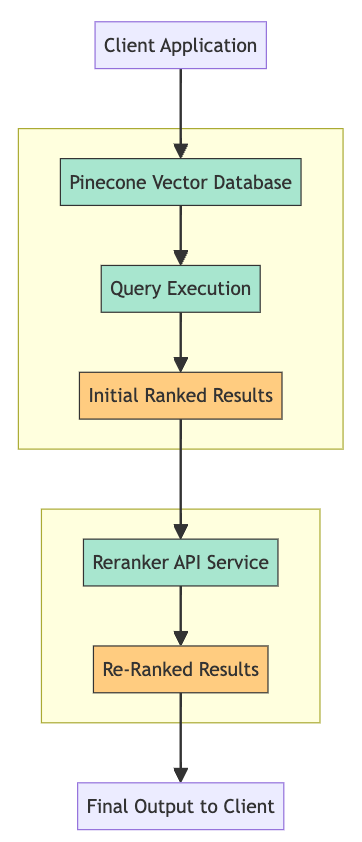

### Steps in This Notebook:

1. **Load Libraries**
2. **Load Small Documents Object**
3. **Execute Reranking Model**
4. **Show Results**
5. **Create Index**
6. **Upsert Sample Data**
7. **Embed Query**
8. **Execute Search**
9. **View Results**
10. **Rerank Results**


The main dataset we will be using consists of randomly generated doctor’s notes sample data. The original JSON data has been embedded into vectors, which we will load into Pinecone.


In [1]:
# Installation
!pip install -qU pinecone==8.0.0 pinecone-notebooks

In [2]:
import os

if not os.environ.get("PINECONE_API_KEY"):
    from pinecone_notebooks.colab import Authenticate

    Authenticate()

In [3]:
from pinecone import Pinecone

api_key = os.environ.get("PINECONE_API_KEY")

# Instantiate the Pinecone client
pc = Pinecone(api_key=api_key)

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Create query and documents
query = "Tell me about Apple's products"
documents = [
    "Apple is a popular fruit known for its sweetness and crisp texture.",
    "Apple is known for its innovative products like the iPhone.",
    "Many people enjoy eating apples as a healthy snack.",
    "Apple Inc. has revolutionized the tech industry with its sleek designs and user-friendly interfaces.",
    "An apple a day keeps the doctor away, as the saying goes.",
]

In [5]:
documents

['Apple is a popular fruit known for its sweetness and crisp texture.',
 'Apple is known for its innovative products like the iPhone.',
 'Many people enjoy eating apples as a healthy snack.',
 'Apple Inc. has revolutionized the tech industry with its sleek designs and user-friendly interfaces.',
 'An apple a day keeps the doctor away, as the saying goes.']

In [6]:
from pinecone import RerankModel

# Perform reranking to get top_n results based on the query
reranked_results = pc.inference.rerank(
    model=RerankModel.Bge_Reranker_V2_M3,
    query=query,
    documents=documents,
    top_n=3,
    return_documents=True,
)

In [7]:
def show_reranked_results(query, matches):
    """A utility function to print our reranked results"""
    print(f"Query: {query}")
    print("Reranked Results:")
    for i, match in enumerate(matches):
        print(f"{str(i + 1).rjust(4)}. Score: {match.score}")
        print(f"      Document: {match.document.text}")
        print("")


# Note the reranker ranks Apple the company over apple the fruit based on the context of the query
show_reranked_results(query, reranked_results.data)

Query: Tell me about Apple's products
Reranked Results:
   1. Score: 0.83907574
      Document: Apple is known for its innovative products like the iPhone.

   2. Score: 0.23196201
      Document: Apple Inc. has revolutionized the tech industry with its sleek designs and user-friendly interfaces.

   3. Score: 0.1742697
      Document: Apple is a popular fruit known for its sweetness and crisp texture.



### Enhanced Medical Note Retrieval for Improved Clinical Decision-Making
**Scenario**: A healthcare system allows doctors to search through a large dataset of medical notes to find relevant patient information.

**Application**: After an initial list of relevant notes is generated from a search query, a reranker can fine-tune the order by considering factors such as the specificity of the medical conditions mentioned, and the relevance to the patient's current symptoms or treatment plan. This ensures that the most critical and contextually relevant notes are presented first, aiding in quicker and more accurate clinical decision-making.

In [8]:
!pip install pandas torch transformers

In [9]:
import os
import time
import pandas as pd
from pinecone import Pinecone, ServerlessSpec
from transformers import AutoTokenizer, AutoModel
import torch

In [10]:
# Get cloud and region settings
cloud = os.getenv("PINECONE_CLOUD", "aws")
region = os.getenv("PINECONE_REGION", "us-east-1")

# Define serverless specifications
spec = ServerlessSpec(cloud=cloud, region=region)

# Define index name
index_name = "pinecone-reranker"

In [11]:
if pc.has_index(name=index_name):
    pc.delete_index(name=index_name)

# Create a new index
pc.create_index(name=index_name, dimension=384, metric="cosine", spec=spec)

{
    "name": "pinecone-reranker",
    "metric": "cosine",
    "host": "pinecone-reranker-dojoi3u.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 384,
    "deletion_protection": "disabled",
    "tags": null
}

### Load Data

In [13]:
import requests
import tempfile

with tempfile.TemporaryDirectory() as tmpdirname:
    # Construct the full path for the file within the temporary directory.
    file_path = os.path.join(tmpdirname, "sample_notes_data.jsonl")

    # Download the file from github
    url = "https://raw.githubusercontent.com/pinecone-io/examples/refs/heads/master/docs/data/sample_notes_data.jsonl"
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for any HTTP errors.

    # Write the file content to the temporary directory.
    with open(file_path, "wb") as f:
        f.write(response.content)

    df = pd.read_json(file_path, orient="records", lines=True)

# Show head of the DataFrame
df.head()

,id,values,metadata
0,P011,"[-0.2027486265, 0.2769146562, -0.1509393603, 0...","{'advice': 'rest, hydrate', 'symptoms': 'heada..."
1,P001,"[0.1842793673, 0.4459365904, -0.0770567134, 0....","{'tests': 'EKG, stress test', 'symptoms': 'che..."
2,P002,"[-0.2040648609, -0.1739618927, -0.2897160649, ...","{'HbA1c': '7.2', 'condition': 'diabetes', 'med..."
3,P003,"[0.1889383644, 0.2924542725, -0.2335938066, -0...","{'symptoms': 'cough, wheezing', 'diagnosis': '..."
4,P004,"[-0.12171068040000001, 0.1674752235, -0.231888...","{'referral': 'dermatology', 'condition': 'susp..."


### Upsert data to the index

In [14]:
# Instantiate an index client
index = pc.Index(name=index_name)

# Upsert data into index from DataFrame
index.upsert_from_dataframe(df)

sending upsert requests: 100%|██████████| 100/100 [00:00<00:00, 200.29it/s]


{'upserted_count': 100}

In [15]:
import time


def is_fresh(index):
    stats = index.describe_index_stats()
    vector_count = stats.total_vector_count
    print(f"Vector count: ", vector_count)
    return vector_count > 0


while not is_fresh(index):
    # It takes a few moments for vectors we just upserted
    # to become available for querying
    time.sleep(5)

# View index stats
index.describe_index_stats()

Vector count:  0
Vector count:  0
Vector count:  0
Vector count:  0
Vector count:  0
Vector count:  0
Vector count:  0
Vector count:  0
Vector count:  0
Vector count:  100


{'dimension': 384,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 100}},
 'total_vector_count': 100,
 'vector_type': 'dense'}

## Embedding Function


In [16]:
def get_embedding(input_question):
    model_name = "sentence-transformers/all-MiniLM-L6-v2"  # HuggingFace Model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    encoded_input = tokenizer(
        input_question, padding=True, truncation=True, return_tensors="pt"
    )

    with torch.no_grad():
        model_output = model(**encoded_input)

    embedding = model_output.last_hidden_state[0].mean(dim=0)
    return embedding

## Execute Query

In [17]:
# Build a query to search
question = "what if my patient has leg pain"
query = get_embedding(question).tolist()

# Get results
results = index.query(vector=[query], top_k=10, include_metadata=True)

# Sort results by score in descending order
sorted_matches = sorted(results["matches"], key=lambda x: x["score"], reverse=True)

/pytorch/third_party/ideep/mkl-dnn/src/cpu/aarch64/xbyak_aarch64/src/util_impl_linux.h, 451: Can't read MIDR_EL1 sysfs entry


## Show Results

In [18]:
def show_results(question, matches):
    """A utility function to print our results"""
    print(f"Question: '{question}'")
    print("\nResults:")
    for i, match in enumerate(matches):
        print(f"{str(i + 1).rjust(4)}. ID: {match['id']}")
        print(f"      Score: {match['score']}")
        print(f"      Metadata: {match['metadata']}")
        print("")

In [19]:
show_results(question, sorted_matches)

Question: 'what if my patient has leg pain'

Results:
   1. ID: P0100
      Score: 0.517953098
      Metadata: {'advice': 'over-the-counter pain relief, stretching', 'symptoms': 'muscle pain'}

   2. ID: P095
      Score: 0.500854671
      Metadata: {'symptoms': 'back pain', 'treatment': 'physical therapy'}

   3. ID: P047
      Score: 0.500854671
      Metadata: {'symptoms': 'back pain', 'treatment': 'physical therapy'}

   4. ID: P007
      Score: 0.459922969
      Metadata: {'surgery': 'knee arthroscopy', 'symptoms': 'pain, swelling', 'treatment': 'physical therapy'}

   5. ID: P028
      Score: 0.446633637
      Metadata: {'condition': 'knee pain', 'referral': 'orthopedics'}

   6. ID: P059
      Score: 0.429972351
      Metadata: {'symptoms': 'joint pain', 'treatment': 'NSAIDs, rest'}

   7. ID: P020
      Score: 0.424824864
      Metadata: {'condition': 'sprained ankle', 'tests': 'X-ray'}

   8. ID: P068
      Score: 0.414039701
      Metadata: {'condition': 'broken arm', 'treatm

### Perform Rerank

In [20]:
# Create documents with concatenated metadata field as "reranking_field" field
transformed_documents = [
    {
        "id": match["id"],
        "reranking_field": "; ".join(
            [f"{key}: {value}" for key, value in match["metadata"].items()]
        ),
    }
    for match in results["matches"]
]

In [21]:
# Define a more specific query for reranking
query = "what if my patient had knee surgery"

# Perform reranking based on the query and specified field
reranked_results_field = pc.inference.rerank(
    model="bge-reranker-v2-m3",
    query=query,
    documents=transformed_documents,
    rank_fields=["reranking_field"],
    top_n=2,
    return_documents=True,
)

In [22]:
def show_reranked_results(question, matches):
    """A utility function to print our reranked results"""
    print(f"Question: '{question}'")
    print("\nReranked Results:")
    for i, match in enumerate(matches):
        print(f"{str(i + 1).rjust(4)}. ID: {match.document.id}")
        print(f"      Score: {match.score}")
        print(f"      Reranking Field: {match.document.reranking_field}")
        print("")


show_reranked_results(query, reranked_results_field.data)

Question: 'what if my patient had knee surgery'

Reranked Results:
   1. ID: P007
      Score: 0.18184364
      Reranking Field: surgery: knee arthroscopy; symptoms: pain, swelling; treatment: physical therapy

   2. ID: P028
      Score: 0.0054905633
      Reranking Field: condition: knee pain; referral: orthopedics



Now let's delete the index to save resources

In [23]:
pc.delete_index(name=index_name)